# SBI for decision-making models

In [a previous
tutorial](https://sbi-dev.github.io/sbi/latest/tutorials/12_iid_data_and_permutation_invariant_embeddings.md),
we showed how to use SBI with trial-based iid data. Such scenarios can arise,
for example, in models of perceptual decision making. In addition to trial-based
iid data points, these models often come with mixed data types and varying
experimental conditions. Here, we show how `sbi` can be used to perform
inference in such models with the `MNLE` method.


Note, you find the original version of this notebook in the `sbi` repository under
[tutorials/Example_01_DecisionMakingModel.ipynb](https://github.com/sbi-dev/sbi/blob/main/tutorials/Example_01_DecisionMakingModel.ipynb).

## Trial-based SBI with mixed data types

In some cases, models with trial-based data additionally return data with mixed data types, e.g., continous and discrete data. For example, most computational models of decision-making have continuous reaction times and discrete choices as output.

This can induce a problem when performing trial-based SBI that relies on learning a neural likelihood: It is challenging for most density estimators to handle both, continuous and discrete data at the same time.
However, there is a recent SBI method for solving this problem, it's called **Mixed Neural Likelihood Estimation** (MNLE). It works just like NLE, but with mixed data types. The trick is that it learns two separate density estimators, one for the discrete part of the data, and one for the continuous part, and combines the two to obtain the final neural likelihood. Crucially, the continuous density estimator is trained conditioned on the output of the discrete one, such that statistical dependencies between the discrete and continuous data (e.g., between choices and reaction times) are modeled as well. The interested reader is referred to the original paper available [here](https://elifesciences.org/articles/77220).

MNLE was recently added to `sbi` (see this [PR](https://github.com/mackelab/sbi/pull/638) and also [issue](https://github.com/mackelab/sbi/issues/845)) and follows the same API as `SNLE`.

In this tutorial we will show how to apply `MNLE` to mixed data, and how to deal with varying experimental conditions.


## Toy problem for `MNLE`

To illustrate `MNLE` we set up a toy simulator that outputs mixed data and for which we know the likelihood such we can obtain reference posterior samples via MCMC.

**Simulator**: To simulate mixed data we do the following

- Sample reaction time from `inverse Gamma`
- Sample choices from `Binomial`
- Return reaction time $rt \in (0, \infty)$ and choice index $c \in \{0, 1\}$

$$
c \sim \text{Binomial}(\rho) \\
rt \sim \text{InverseGamma}(\alpha=2, \beta) \\
$$

**Prior**: The priors of the two parameters $\rho$ and $\beta$ are independent. We define a `Beta` prior over the probabilty parameter of the `Binomial` used in the simulator and a `Gamma` prior over the shape-parameter of the `inverse Gamma` used in the simulator:

$$
p(\beta, \rho) = p(\beta) \; p(\rho) ; \\
p(\beta) = \text{Gamma}(1, 0.5) \\
p(\text{probs}) = \text{Beta}(2, 2)
$$

Because the `InverseGamma` and the `Binomial` likelihoods are well-defined we can perform MCMC on this problem and obtain reference-posterior samples.


In [1]:
import matplotlib.pyplot as plt
import torch
from pyro.distributions import InverseGamma
from torch import Tensor
from torch.distributions import Beta, Binomial, Gamma, Distribution
from typing import Union

from sbi.analysis import pairplot
from sbi.inference import MNLE, MCMCPosterior
from sbi.inference.potentials.base_potential import BasePotential
from sbi.inference.potentials.likelihood_based_potential import LikelihoodBasedPotential
from sbi.utils import BoxUniform, MultipleIndependent, mcmc_transform
from sbi.utils.metrics import c2st
from sbi.utils.torchutils import atleast_2d

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
# Toy simulator for mixed data
def mixed_simulator(theta: Tensor, concentration_scaling: float = 1.0):
    """Returns a sample from a mixed distribution given parameters theta.

    Args:
        theta: batch of parameters, shape (batch_size, 2) concentration_scaling:
        scaling factor for the concentration parameter of the InverseGamma
        distribution, mimics an experimental condition.

    """
    beta, rho = theta[:, :1], theta[:, 1:]

    choices = Binomial(probs=rho).sample()
    rts = InverseGamma(
        concentration=concentration_scaling * torch.ones_like(beta), rate=beta
    ).sample()

    return torch.cat((rts, choices), dim=1)


class BinomialGammaPotential(BasePotential):
    """Binomial-Gamma potential for mixed data."""

    def __init__(
        self,
        prior: Distribution,
        x_o: Tensor,
        concentration_scaling: Union[Tensor, float] = 1.0,
        device="cpu",
    ):
        super().__init__(prior, x_o, device)

        # concentration_scaling needs to be a float or match the batch size
        if isinstance(concentration_scaling, Tensor):
            num_trials = x_o.shape[0]
            assert concentration_scaling.shape[0] == num_trials

            # Reshape to match convention (batch_size, num_trials, *event_shape)
            concentration_scaling = concentration_scaling.reshape(1, num_trials, -1)

        self.concentration_scaling = concentration_scaling

    def __call__(self, theta: Tensor, track_gradients: bool = True) -> Tensor:
        theta = atleast_2d(theta)

        with torch.set_grad_enabled(track_gradients):
            iid_ll = self.iid_likelihood(theta)

        return iid_ll + self.prior.log_prob(theta)

    def iid_likelihood(self, theta: Tensor) -> Tensor:
        batch_size = theta.shape[0]
        num_trials = self.x_o.shape[0]
        theta = theta.reshape(batch_size, 1, -1)
        beta, rho = theta[:, :, :1], theta[:, :, 1:]

        # vectorized
        logprob_choices = Binomial(probs=rho).log_prob(
            self.x_o[:, 1:].reshape(1, num_trials, -1)
        )

        logprob_rts = InverseGamma(
            concentration=self.concentration_scaling * torch.ones_like(beta),
            rate=beta,
        ).log_prob(self.x_o[:, :1].reshape(1, num_trials, -1))

        joint_likelihood = (logprob_choices + logprob_rts).squeeze()

        assert joint_likelihood.shape == torch.Size([theta.shape[0], self.x_o.shape[0]])
        return joint_likelihood.sum(1)

In [3]:
# Define independent prior.
prior = MultipleIndependent(
    [
        Gamma(torch.tensor([1.0]), torch.tensor([0.5])),
        Beta(torch.tensor([2.0]), torch.tensor([2.0])),
    ],
    validate_args=False,
)

### Obtain reference-posterior samples via analytical likelihood and MCMC


In [4]:
torch.manual_seed(42)
num_trials = 10
num_samples = 1000
theta_o = prior.sample((1,))
x_o = mixed_simulator(theta_o.repeat(num_trials, 1))

In [5]:
mcmc_kwargs = dict(
    num_chains=20,
    warmup_steps=50,
    method="slice_np_vectorized",
    init_strategy="proposal",
)

true_posterior = MCMCPosterior(
    potential_fn=BinomialGammaPotential(prior, x_o),
    proposal=prior,
    theta_transform=mcmc_transform(prior, enable_transform=True),
    **mcmc_kwargs,
)
true_samples = true_posterior.sample((num_samples,))

/Users/janteusen/qode/sbi/sbi/inference/posteriors/mcmc_posterior.py:115: UserWarning: The default value for thinning in MCMC sampling has been changed from 10 to 1. This might cause the results differ from the last benchmark.
  thin = _process_thin_default(thin)


Running vectorized MCMC with 20 chains:   0%|          | 0/3000 [00:00<?, ?it/s]

### Train MNLE and generate samples via MCMC


In [6]:
# Training data
num_simulations = 10000
# For training the MNLE emulator we need to define a proposal distribution, the prior is
# a good choice.
proposal = prior
theta = proposal.sample((num_simulations,))
x = mixed_simulator(theta)

# Train MNLE and obtain MCMC-based posterior.
trainer = MNLE()
estimator = trainer.append_simulations(theta, x).train()

/Users/janteusen/qode/sbi/sbi/neural_nets/factory.py:205: UserWarning: The mixed neural likelihood estimator assumes that x contains continuous data in the first n-1 columns (e.g., reaction times) and categorical data in the last column (e.g., corresponding choices). If this is not the case for the passed `x` do not use this function.
  return model_builders[model](batch_x=batch_x, batch_y=batch_theta, **kwargs)


 Neural network successfully converged after 70 epochs.

In [7]:
# Build posterior from the trained estimator and prior.
mnle_posterior = trainer.build_posterior(prior=prior)

mnle_samples = mnle_posterior.sample((num_samples,), x=x_o, **mcmc_kwargs)

Running vectorized MCMC with 20 chains:   0%|          | 0/3000 [00:00<?, ?it/s]

### Compare MNLE and reference posterior


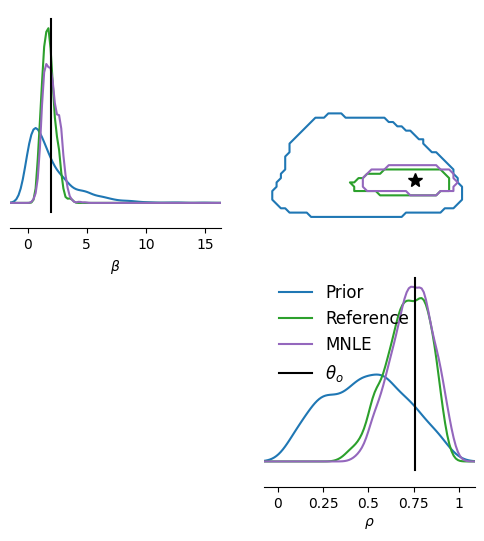

In [8]:
# Plot them in one pairplot as contours (obtained via KDE on the samples).
fig, ax = pairplot(
    [
        prior.sample((1000,)),
        true_samples,
        mnle_samples,
    ],
    points=theta_o,
    diag="kde",
    upper="contour",
    upper_kwargs=dict(levels=[0.95]),
    diag_kwargs=dict(bins=100),
    fig_kwargs=dict(
        points_offdiag=dict(marker="*", markersize=10),
        points_colors=["k"],
    ),
    labels=[r"$\beta$", r"$\rho$"],
    figsize=(6, 6),
)

plt.sca(ax[1, 1])
plt.legend(
    ["Prior", "Reference", "MNLE", r"$\theta_o$"],
    frameon=False,
    fontsize=12,
);

We see that the inferred `MNLE` posterior nicely matches the reference posterior, and how both inferred a posterior that is quite different from the prior.

Because MNLE training is amortized we can obtain another posterior given a different observation with potentially a different number of trials, just by running MCMC again (without re-training `MNLE`):


### Repeat inference with different `x_o` that contains more trials


In [9]:
num_trials = 50
x_o = mixed_simulator(theta_o.repeat(num_trials, 1))
true_samples = true_posterior.sample((num_samples,), x=x_o, **mcmc_kwargs)
mnle_samples = mnle_posterior.sample((num_samples,), x=x_o, **mcmc_kwargs)

Running vectorized MCMC with 20 chains:   0%|          | 0/3000 [00:00<?, ?it/s]

Running vectorized MCMC with 20 chains:   0%|          | 0/3000 [00:00<?, ?it/s]

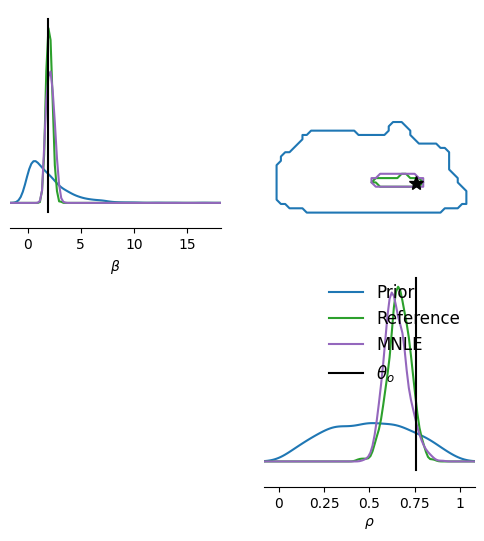

In [10]:
# Plot them in one pairplot as contours (obtained via KDE on the samples).
fig, ax = pairplot(
    [
        prior.sample((1000,)),
        true_samples,
        mnle_samples,
    ],
    points=theta_o,
    diag="kde",
    upper="contour",
    diag_kwargs=dict(bins=100),
    upper_kwargs=dict(levels=[0.95]),
    fig_kwargs=dict(
        points_offdiag=dict(marker="*", markersize=10),
        points_colors=["k"],
    ),
    labels=[r"$\beta$", r"$\rho$"],
    figsize=(6, 6),
)

plt.sca(ax[1, 1])
plt.legend(
    ["Prior", "Reference", "MNLE", r"$\theta_o$"],
    frameon=False,
    fontsize=12,
);

In [11]:
print("c2st between true and MNLE posterior:", c2st(true_samples, mnle_samples).item())

c2st between true and MNLE posterior: 0.5605


Again we can see that the posteriors match nicely. In addition, we observe that the posterior's (epistemic) uncertainty reduces as we increase the number of trials.

Note: `MNLE` is trained on single-trial data. Theoretically, density estimation is perfectly accurate only in the limit of infinite training data. Thus, training with a finite amount of training data naturally induces a small bias in the density estimator.
As we observed above, this bias is so small that we don't really notice it, e.g., the `c2st` scores were close to 0.5.
However, when we increase the number of trials in `x_o` dramatically (on the order of 1000s) the small bias can accumulate over the trials and inference with `MNLE` can become less accurate.


## MNLE with experimental conditions

In the perceptual decision-making research, it is common to design experiments with varying experimental decisions, e.g., to vary the difficulty of the task.
During parameter inference, it can be beneficial to incorporate the experimental conditions.

In MNLE, we are learning an emulator that should be able to generate synthetic experimental data including reaction times and choices given different experimental conditions.
Thus, to make MNLE work with experimental conditions, we need to include them in the training process, i.e., treat them like auxiliary parameters of the simulator:


In [12]:
# Define a proposal that contains both, priors for the parameters and a discrte
# prior over experimental conditions.
proposal = MultipleIndependent(
    [
        Gamma(torch.tensor([1.0]), torch.tensor([0.5])),
        Beta(torch.tensor([2.0]), torch.tensor([2.0])),
        BoxUniform(torch.tensor([0.0]), torch.tensor([1.0])),
    ],
    validate_args=False,
)

# define a simulator wrapper in which the experimental condition are contained
# in theta and passed to the simulator.
def sim_wrapper(theta_and_conditions):
    # simulate with experiment conditions
    return mixed_simulator(
        # we assume the first two parameters are beta and rho
        theta=theta_and_conditions[:, :2],
        # we treat the third concentration parameter as an experimental condition
        concentration_scaling=theta_and_conditions[:, 2:],
    )

In [13]:
# Simulated data
num_simulations = 10000
num_samples = 1000
theta = proposal.sample((num_simulations,))
x = sim_wrapper(theta)
assert x.shape == (num_simulations, 2)

# simulate observed data and define ground truth parameters
num_trials = 10
# draw one ground truth parameter
theta_o = proposal.sample((1,))[:, :2]
# draw num_trials many different conditions
conditions = proposal.sample((num_trials,))[:, 2:]
# Theta is repeated for each trial, conditions are different for each trial.
theta_and_conditions_o = torch.cat((theta_o.repeat(num_trials, 1), conditions), dim=1)
x_o = sim_wrapper(theta_and_conditions_o)

#### Obtain ground truth posterior via MCMC

We obtain a ground-truth posterior via MCMC by using the PotentialFunctionProvider.

For that, we first the define the actual prior, i.e., the distribution over the parameter we want to infer (not the proposal).

Thus, we leave out the discrete prior over experimental conditions.


In [14]:
prior = MultipleIndependent(
    [
        Gamma(torch.tensor([1.0]), torch.tensor([0.5])),
        Beta(torch.tensor([2.0]), torch.tensor([2.0])),
    ],
    validate_args=False,
)
prior_transform = mcmc_transform(prior)

# We can now use the PotentialFunctionProvider to obtain a ground-truth
# posterior via MCMC.
true_posterior_samples = MCMCPosterior(
    BinomialGammaPotential(
        prior,
        x_o,
        concentration_scaling=conditions,
    ),
    theta_transform=prior_transform,
    proposal=prior,
    **mcmc_kwargs,
).sample((num_samples,), show_progress_bars=True)

/Users/janteusen/qode/sbi/sbi/inference/posteriors/mcmc_posterior.py:115: UserWarning: The default value for thinning in MCMC sampling has been changed from 10 to 1. This might cause the results differ from the last benchmark.
  thin = _process_thin_default(thin)


Running vectorized MCMC with 20 chains:   0%|          | 0/3000 [00:00<?, ?it/s]

KeyboardInterrupt: 

### Train MNLE including experimental conditions


In [15]:
from sbi.neural_nets import likelihood_nn

estimator_builder = likelihood_nn(model="mnle", z_score_x=None)
trainer = MNLE(proposal, estimator_builder)
estimator = trainer.append_simulations(theta, x).train()

/Users/janteusen/qode/sbi/sbi/inference/trainers/base.py:271: UserWarning: Z-scoring these simulation outputs resulted in 4 unique datapoints. Before z-scoring, it had been 19864. This can occur due to numerical inaccuracies when the data covers a large range of values. Consider either setting `z_score_x=False` (but beware that this can be problematic for training the NN) or exclude outliers from your dataset. Note: if you have already set `z_score_x=False`, this warning will still be displayed, but you can ignore it.
  warn_if_zscoring_changes_data(x)
/Users/janteusen/qode/sbi/sbi/neural_nets/factory.py:205: UserWarning: The mixed neural likelihood estimator assumes that x contains continuous data in the first n-1 columns (e.g., reaction times) and categorical data in the last column (e.g., corresponding choices). If this is not the case for the passed `x` do not use this function.
  return model_builders[model](batch_x=batch_x, batch_y=batch_theta, **kwargs)


 Neural network successfully converged after 102 epochs.

### Construct conditional potential function

We have now an emulator for the extended simulator, i.e., the one that has both the
model parameters and the experimental condition as parameters. 

To obtain posterior
samples conditioned on a particular experimental condition (and on x_o), we need to
construct a corresponding potential function that can return the log likelihood of the
model parameters, but conditioned on the experimental condition.


In [16]:
# We define the potential function for the complete, unconditional MNLE-likelihood
potential_fn = LikelihoodBasedPotential(estimator, proposal, x_o)
conditioned_potential_fn = potential_fn.condition_on(conditions, dims_to_sample=[0, 1])

# Using this potential function, we can now obtain conditional samples.
mnle_posterior = MCMCPosterior(
    potential_fn=conditioned_potential_fn,
    theta_transform=prior_transform,
    proposal=prior,
    **mcmc_kwargs
)
conditional_samples = mnle_posterior.sample((num_samples,), x=x_o)

Running vectorized MCMC with 20 chains:   0%|          | 0/3000 [00:00<?, ?it/s]

In [ ]:
# Finally, we can compare the ground truth conditional posterior with the
# MNLE-conditional posterior.
fig, ax = pairplot(
    [
        prior.sample((1000,)),
        true_posterior_samples,
        conditional_samples,
    ],
    points=theta_o,
    diag="kde",
    upper="contour",
    diag_kwargs=dict(bins=100),
    upper_kwargs=dict(levels=[0.95]),
    fig_kwargs=dict(
        points_offdiag=dict(marker="*", markersize=10),
        points_colors=["k"],
    ),
    labels=[r"$\beta$", r"$\rho$"],
)

plt.sca(ax[1, 1])
plt.legend(
    ["Prior", "Reference", "MNLE", r"$\theta_o$"],
    frameon=False,
    fontsize=12,
);
print("c2st between true and MNLE posterior:", c2st(true_posterior_samples, conditional_samples).item())

They match accurately, showing that we can indeed post-hoc condition the trained MNLE likelihood on different experimental conditions.
